In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.driver.maxResultSize', '18g').getOrCreate()

In [0]:
pip install nltk

Python interpreter will be restarted.
Collecting nltk
 Downloading nltk-3.7-py3-none-any.whl (1.5 MB)
Requirement already satisfied: joblib in /databricks/python3/lib/python3.8/site-packages (from nltk) (1.0.1)
Collecting click
 Downloading click-8.1.3-py3-none-any.whl (96 kB)
Collecting regex>=2021.8.3
 Downloading regex-2022.9.13-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (772 kB)
Collecting tqdm
 Downloading tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
Installing collected packages: tqdm, regex, click, nltk
Successfully installed click-8.1.3 nltk-3.7 regex-2022.9.13 tqdm-4.64.1
Python interpreter will be restarted.

In [0]:
pip install wordcloud

Python interpreter will be restarted.
Collecting wordcloud
 Downloading wordcloud-1.8.2.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (458 kB)
Requirement already satisfied: pillow in /databricks/python3/lib/python3.8/site-packages (from wordcloud) (8.2.0)
Requirement already satisfied: numpy>=1.6.1 in /databricks/python3/lib/python3.8/site-packages (from wordcloud) (1.20.1)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from wordcloud) (3.4.2)
Requirement already satisfied: python-dateutil>=2.7 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->wordcloud) (2.8.1)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->wordcloud) (0.10.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->wordcloud) (1.3.1)
Requirement already satisfied: pyparsing>=2.2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->wordcloud) (2.4.7)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib->wordcloud) (1.15.0)
Installing collected packages: wordcloud
Successfully installed wordcloud-1.8.2.2
Python interpreter will be restarted.

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords #停用词
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import string
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Unzipping tokenizers/punkt.zip.

In [0]:
def remove_upprintable_chars(s):
    
    return ''.join(x for x in s if x.isprintable())
# 分词操作是 word_tokenize() 之后转换成小写
def preprocess(text):
        text = re.sub('[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~\s]+', " ", text)
        text = re.sub('[\001\002\003\004\005\006\007\n\x08\x09\x0a\x0b\x0c\x0d\x0e\x0f\x10\x11\x80\x90\x12\x13\x14\x15\x16\x17\x18\x19\x1a]+', '', text)
        tokens= word_tokenize(text)
        token_list =[remove_upprintable_chars(word.lower()) for word in tokens]
        filtered=[w for w in token_list if(w not in stopwords.words('english'))]
        
        return ' '.join(filtered)

In [0]:
from pyspark.sql.functions import lit,col
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [0]:
path = "dbfs:/mnt/lsde/group05/comment_position_3class/2014-10.parquet"

In [0]:
df = spark.read.load(path,format="parquet")

In [0]:
df.show()

+---------+-------+------+-----------+
parent_id| id|result|created_utc|
+---------+-------+------+-----------+
t3_2kqbtf|clntp5k| [2.0]| 1414635828|
t3_2kqrmh|clntqqy| [2.0]| 1414635917|
t3_2kqrh4|clntr0k| [2.0]| 1414635930|
t3_2kqrk0|clntrhx| [1.0]| 1414635956|
t3_2kjir6|clntrvs| [2.0]| 1414635977|
t3_2kqrh4|clnts26| [2.0]| 1414635987|
t3_2kqrh4|clntu3x| [2.0]| 1414636101|
t3_2kp8o5|clntxa2| [2.0]| 1414636272|
t3_2kp3k3|clntxp1| [2.0]| 1414636293|
t3_2kjetv|clntz0p| [2.0]| 1414636366|
t3_2kqsjg|clnu10e| [2.0]| 1414636479|
t3_2kqslb|clnu2xz| [2.0]| 1414636584|
t3_2kqrrv|clnu4x9| [2.0]| 1414636684|
t3_2kqpwy|clnu76b| [2.0]| 1414636807|
t3_2kqrrv|clnucx4| [2.0]| 1414637122|
t3_2kqrh4|clnue6d| [2.0]| 1414637192|
t3_2kqbtf|clnue6z| [2.0]| 1414637193|
t3_2kqrh4|clnui4v| [2.0]| 1414637405|
t3_2kqanl|clnulpk| [2.0]| 1414637599|
t3_2kqp9o|clnumda| [2.0]| 1414637638|
+---------+-------+------+-----------+
only showing top 20 rows

In [0]:
def handle(year_range = [2015, 2016, 2017], month_range = range(1, 13)):
    df_samples = None
    for year in year_range:
        
        for month in month_range:
            
            month_literal = str(month)
            data_path = "/mnt/lsde/group05/comment_position_3class/" + str(year) + "-" + month_literal + ".parquet"
            print("start handling "+str(year) + "-" + month_literal)
            df =spark.read.load(data_path,format="parquet")
            df_sam = df.sample(fraction=0.01,seed = 123)
            
            text_path = "/mnt/lsde/group05/filtered_comments/" + str(year) + "-" + month_literal + ".parquet"
            comment_text = spark.read.load(text_path,format="parquet")
            df_comment_all=df_sam.join(comment_text,"id").select(df_sam.id,"body","result")
            if df_samples is None:
                df_samples = df_comment_all
            else:
                df_samples = df_samples.union(df_comment_all)
            print("finish handling "+str(year) + "-" + month_literal)
    return df_samples
        

In [0]:
comment_201402=handle([2014],[2])

start handling 2014-2
finish handling 2014-2

In [0]:
comment_201402.show()

+-------+--------------------+------+
 id| body|result|
+-------+--------------------+------+
cfrfp8k|[Could do with so...| [2.0]|
cfrhunl|"Gov. Romney, I'm...| [1.0]|
cfri2rz|The last thing th...| [2.0]|
cfribpr|God Europe, get y...| [2.0]|
cfribrp|Obama and the res...| [0.0]|
cfrj88c|World War III her...| [0.0]|
cfrk5qz|Anyone else hate ...| [0.0]|
cfrl7p4|LoL Ok Obama, you...| [2.0]|
cfrmwqu|US , Nato , and E...| [1.0]|
cfrsoql|&gt;16:55 GMT: Th...| [0.0]|
cfrt39i|it must be sooo s...| [0.0]|
cfiw5q1|There's an expres...| [2.0]|
cfiy0iw|Let me just wipe ...| [2.0]|
cfiyls4|I hope it, too. I...| [0.0]|
cfj00q3| No music, huh...?| [2.0]|
cfj0gg7| What happened here?| [2.0]|
cfj0jir|Watch him come ou...| [2.0]|
cfj1ikp|Yeah, one time i ...| [2.0]|
cfj5v9e|even if it gets d...| [2.0]|
cfj6450|The team will be ...| [2.0]|
+-------+--------------------+------+
only showing top 20 rows

In [0]:
comment_201402.show()

+-------+--------------------+------+
 id| body|result|
+-------+--------------------+------+
cfqdgqd|Bread and Circuse...| [0.0]|
cfqf2yl|Cut off all internet| [0.0]|
cfqgyd1|Absolutely nothing. | [0.0]|
cfqh334|http://www.dreamd...| [1.0]|
cfqjgwc|Not until public ...| [0.0]|
cfqo2af|Nice of their hoc...| [0.0]|
cfqpjoj|##Quick Summary: ...| [0.0]|
cfqqyth|Mercedes, that he...| [0.0]|
cfllwem|The unsung hero i...| [0.0]|
cflnec6|Downvoted cause i...| [0.0]|
cflo73i|I know very littl...| [1.0]|
cfloggd|Spend 70 years ha...| [0.0]|
cflu8gi|I have one for pr...| [0.0]|
cflv34d|WOW! I go to bed ...| [0.0]|
cflwhka|A "best of" comme...| [0.0]|
cflz1wn|He spent a few ye...| [0.0]|
cfm1uyb|My pup. Good thin...| [0.0]|
cfm5sdu|Japanese, but it ...| [0.0]|
cfm67ac|My jerkass cat, d...| [1.0]|
cfa5yvw|What you perceive...| [0.0]|
+-------+--------------------+------+
only showing top 20 rows

In [0]:
comment_2014 = handle([2014],range(2,13))

start handling 2014-2
finish handling 2014-2
start handling 2014-3
finish handling 2014-3
start handling 2014-4
finish handling 2014-4
start handling 2014-5
finish handling 2014-5
start handling 2014-6
finish handling 2014-6
start handling 2014-7
finish handling 2014-7
start handling 2014-8
finish handling 2014-8
start handling 2014-9
finish handling 2014-9
start handling 2014-10
finish handling 2014-10
start handling 2014-11
finish handling 2014-11
start handling 2014-12
finish handling 2014-12

In [0]:
comment_from2015= handle(range(2015,2022),range(1,13))

start handling 2015-1
finish handling 2015-1
start handling 2015-2
finish handling 2015-2
start handling 2015-3
finish handling 2015-3
start handling 2015-4
finish handling 2015-4
start handling 2015-5
finish handling 2015-5
start handling 2015-6
finish handling 2015-6
start handling 2015-7
finish handling 2015-7
start handling 2015-8
finish handling 2015-8
start handling 2015-9
finish handling 2015-9
start handling 2015-10
finish handling 2015-10
start handling 2015-11
finish handling 2015-11
start handling 2015-12
finish handling 2015-12
start handling 2016-1
finish handling 2016-1
start handling 2016-2
finish handling 2016-2
start handling 2016-3
finish handling 2016-3
start handling 2016-4
finish handling 2016-4
start handling 2016-5
finish handling 2016-5
start handling 2016-6
finish handling 2016-6
start handling 2016-7
finish handling 2016-7
start handling 2016-8
finish handling 2016-8
start handling 2016-9
finish handling 2016-9
start handling 2016-10
finish handling 2016-10
start handling 2016-11
finish handling 2016-11
start handling 2016-12
finish handling 2016-12
start handling 2017-1
finish handling 2017-1
start handling 2017-2
finish handling 2017-2
start handling 2017-3
finish handling 2017-3
start handling 2017-4
finish handling 2017-4
start handling 2017-5
finish handling 2017-5
start handling 2017-6
finish handling 2017-6
start handling 2017-7
finish handling 2017-7
start handling 2017-8
finish handling 2017-8
start handling 2017-9
finish handling 2017-9
start handling 2017-10
finish handling 2017-10
start handling 2017-11
finish handling 2017-11
start handling 2017-12
finish handling 2017-12
start handling 2018-1
finish handling 2018-1
start handling 2018-2
finish handling 2018-2
start handling 2018-3
finish handling 2018-3
start handling 2018-4
finish handling 2018-4
start handling 2018-5
finish handling 2018-5
start handling 2018-6
finish handling 2018-6
start handling 2018-7
finish handling 2018-7
start handling 2018-8
finish handling 2018-8
start handling 2018-9
finish handling 2018-9
start handling 2018-10
finish handling 2018-10
start handling 2018-11
finish handling 2018-11
start handling 2018-12
finish handling 2018-12
start handling 2019-1
finish handling 2019-1
start handling 2019-2
finish handling 2019-2
start handling 2019-3
finish handling 2019-3
start handling 2019-4
finish handling 2019-4
start handling 2019-5
finish handling 2019-5
start handling 2019-6
finish handling 2019-6
start handling 2019-7
finish handling 2019-7
start handling 2019-8
finish handling 2019-8
start handling 2019-9
finish handling 2019-9
start handling 2019-10
finish handling 2019-10
start handling 2019-11
finish handling 2019-11
start handling 2019-12
finish handling 2019-12
start handling 2020-1
finish handling 2020-1
start handling 2020-2
finish handling 2020-2
start handling 2020-3
finish handling 2020-3
start handling 2020-4
finish handling 2020-4
start handling 2020-5
finish handling 2020-5
start handling 2020-6
finish handling 2020-6
start handling 2020-7
finish handling 2020-7
start handling 2020-8
finish handling 2020-8
start handling 2020-9
finish handling 2020-9
start handling 2020-10
finish handling 2020-10
start handling 2020-11
finish handling 2020-11
start handling 2020-12
finish handling 2020-12
start handling 2021-1
finish handling 2021-1
start handling 2021-2
finish handling 2021-2
start handling 2021-3
finish handling 2021-3
start handling 2021-4
finish handling 2021-4
start handling 2021-5
finish handling 2021-5
start handling 2021-6
finish handling 2021-6
start handling 2021-7
finish handling 2021-7
start handling 2021-8
finish handling 2021-8
start handling 2021-9
finish handling 2021-9
start handling 2021-10
finish handling 2021-10
start handling 2021-11
finish handling 2021-11
start handling 2021-12
finish handling 2021-12

In [0]:
comment_2022 = handle([2022],range(1,9))

start handling 2022-1
finish handling 2022-1
start handling 2022-2
finish handling 2022-2
start handling 2022-3
finish handling 2022-3
start handling 2022-4
finish handling 2022-4
start handling 2022-5
finish handling 2022-5
start handling 2022-6
finish handling 2022-6
start handling 2022-7
finish handling 2022-7
start handling 2022-8
finish handling 2022-8

In [0]:
comments_all =comment_2014.union(comment_from2015).union(comment_2022)

In [0]:
comments_all.write.mode("overwrite").format("parquet").save("/mnt/lsde/group05/"+"wordcloud_comment_sample_new"+".parquet")

In [0]:
#0 for Ukraine 1 for Russia
def judgeAff(lst):
    aff=lst[0]
    if int(float(aff))==1:
        return 1
    elif int(float(aff))==2:
        return 2
    else:
        return 0

In [0]:
judgeAff_f = udf(judgeAff, IntegerType())

In [0]:
spark.udf.register(name="judgeAff_f", f=judgeAff_f)

Out[19]: <function __main__.judgeAff(lst)>

In [0]:
df_withAff = comments_all.withColumn("aff",judgeAff_f('result'))

In [0]:
df_withAff.show()

+-------+--------------------+------+---+
 id| body|result|aff|
+-------+--------------------+------+---+
cfrctfs|favorite part of ...| [2.0]| 2|
cfreqb7|Yeah right Obama,...| [1.0]| 1|
cfrewlz|Is he really Chin...| [0.0]| 0|
cfrfh65|Of course we do, ...| [2.0]| 2|
cfrgsxb|It had been diffi...| [2.0]| 2|
cfrgwfw|What is wrong wit...| [1.0]| 1|
cfrhm14|Meanwhile, Obama ...| [2.0]| 2|
cfriv0p|Heres how we stil...| [1.0]| 1|
cfrjp6x|How does the mini...| [2.0]| 2|
cfrkfz3|DOUBLE SECRET PRO...| [2.0]| 2|
cfrlw2n|Oh ya I'm sure, s...| [2.0]| 2|
cfroioe|So the US can inv...| [0.0]| 0|
cfroju3|The fundamental p...| [2.0]| 2|
cf84vk1|How would taking ...| [2.0]| 2|
cf87tbo| are you retarded| [2.0]| 2|
cf8ndt6|Yep, except that ...| [2.0]| 2|
cf60nj2|For the last time...| [2.0]| 2|
cf629q5|Hell yes I would ...| [2.0]| 2|
cfarwub|Plasticsurgamir P...| [0.0]| 0|
cfitrv3|Guy in LAV should...| [2.0]| 2|
+-------+--------------------+------+---+
only showing top 20 rows

In [0]:
df_Ukr= df_withAff.filter(col('aff')==0)

In [0]:
df_Russia = df_withAff.filter(col('aff')==1)

In [0]:
df_Ukr_pd=df_Ukr.toPandas()

In [0]:
df_Russia_pd = df_Russia.toPandas()

In [0]:
df_Ukr_pd

Out[31]:

,id,body,result,aff
0,cf66wsl,Make it like arcade games in StarCraft 2 and I...,[0.0],0
1,cf686bt,"Hi /u/Adinoadox, please post all links related...",[0.0],0
2,cf6eke0,i got this one because it was supposed to be g...,[0.0],0
3,cf6krjo,This is freaking amazing...how have I never he...,[0.0],0
4,cf6msgi,This news/statement was removed from Volgograd...,[0.0],0
...,...,...,...,...
65767,imgb4do,"Is ""Vokda Gorbatschow"" a thing in other countr...",[0.0],0
65768,imggdvp,sponsored by the kharkiv kid finder,[0.0],0
65769,ijimfk0,Insert the stick in the bike spoke meme,[0.0],0
65770,ijislz2,You don’t have to be bright to play songs,[0.0],0


In [0]:
df_Russia_pd

Out[32]:

,id,body,result,aff
0,cf66iek,Soraka... just... Soraka.,[1.0],1
1,cf6k387,Wasn't the guy who created Enfo's Hero TD in t...,[1.0],1
2,cf6o1oi,wow\n such cccp\n cool it...,[1.0],1
3,cfhjufa,i feel like this picture loses a lot of it's p...,[1.0],1
4,cfv4qbj,Talks in Paris likely to carry on well into th...,[1.0],1
...,...,...,...,...
19366,ikh7apq,📰 [Daily War Summary] Summary of the events wh...,[1.0],1
19367,ikbye9n,"I don't disagree with your sentiment, because ...",[1.0],1
19368,im9zj8n,I'd argue that Russian Fascism would have clas...,[1.0],1
19369,imgajoe,"Why is this ""church"" and these old queens in s...",[1.0],1


In [0]:
df_Ukr_pd['text']=df_Ukr_pd['body'].apply(preprocess)

In [0]:

df_Russia_pd['text'] = df_Russia_pd['body'].apply(preprocess)

In [0]:
df_Russia_pd.head()

Out[35]:

,id,body,result,aff,text
0,cf66iek,Soraka... just... Soraka.,[1.0],1,soraka soraka
1,cf6k387,Wasn't the guy who created Enfo's Hero TD in t...,[1.0],1,guy created enfo hero td talks riot years ago
2,cf6o1oi,wow\n such cccp\n cool it...,[1.0],1,wow cccp cool sickle cold war much communism
3,cfhjufa,i feel like this picture loses a lot of it's p...,[1.0],1,feel like picture loses lot power moscow actua...
4,cfv4qbj,Talks in Paris likely to carry on well into th...,[1.0],1,talks paris likely carry well night u amp russ...


In [0]:
def getWordList(df,lst):
    for i in range(0,len(df)):
        cur =df.iloc[[i],[4]]['text'].values[0].split(' ')
        lst.extend(cur)
    return lst


In [0]:
russia_lst = getWordList(df_Russia_pd,[])

In [0]:
ukr_lst = getWordList(df_Ukr_pd,[])

In [0]:
from collections import Counter
from wordcloud import WordCloud

In [0]:
count_ukr =Counter(ukr_lst)
count_rus=Counter(russia_lst)

In [0]:
count_rus.most_common(50)

Out[45]: [('russia', 7656),
 ('russian', 3847),
 ('like', 3152),
 ('ukraine', 3023),
 ('putin', 2708),
 ('would', 2648),
 ('war', 2457),
 ('us', 2454),
 ('https', 2309),
 ('com', 2285),
 ('trump', 2255),
 ('people', 2033),
 ('one', 1663),
 ('even', 1554),
 ('think', 1543),
 ('gt', 1541),
 ('get', 1490),
 ('r', 1445),
 ('country', 1230),
 ('also', 1230),
 ('www', 1212),
 ('world', 1206),
 ('right', 1104),
 ('going', 1103),
 ('much', 1098),
 ('russians', 1077),
 ('still', 1062),
 ('military', 1057),
 ('back', 1047),
 ('china', 998),
 ('could', 995),
 ('see', 991),
 ('nato', 978),
 ('amp', 964),
 ('u', 959),
 ('time', 941),
 ('know', 941),
 ('well', 933),
 ('want', 922),
 ('good', 896),
 ('really', 889),
 ('way', 886),
 ('make', 866),
 ('go', 824),
 ('countries', 801),
 ('government', 773),
 ('many', 767),
 ('take', 746),
 ('said', 738),
 ('say', 735)]

In [0]:
def gen_wordcloud(tup):
    wordcloud =WordCloud(background_color='white',max_words=70,max_font_size=40,random_state=41).generate(str(tup))
    return wordcloud

Out[34]:

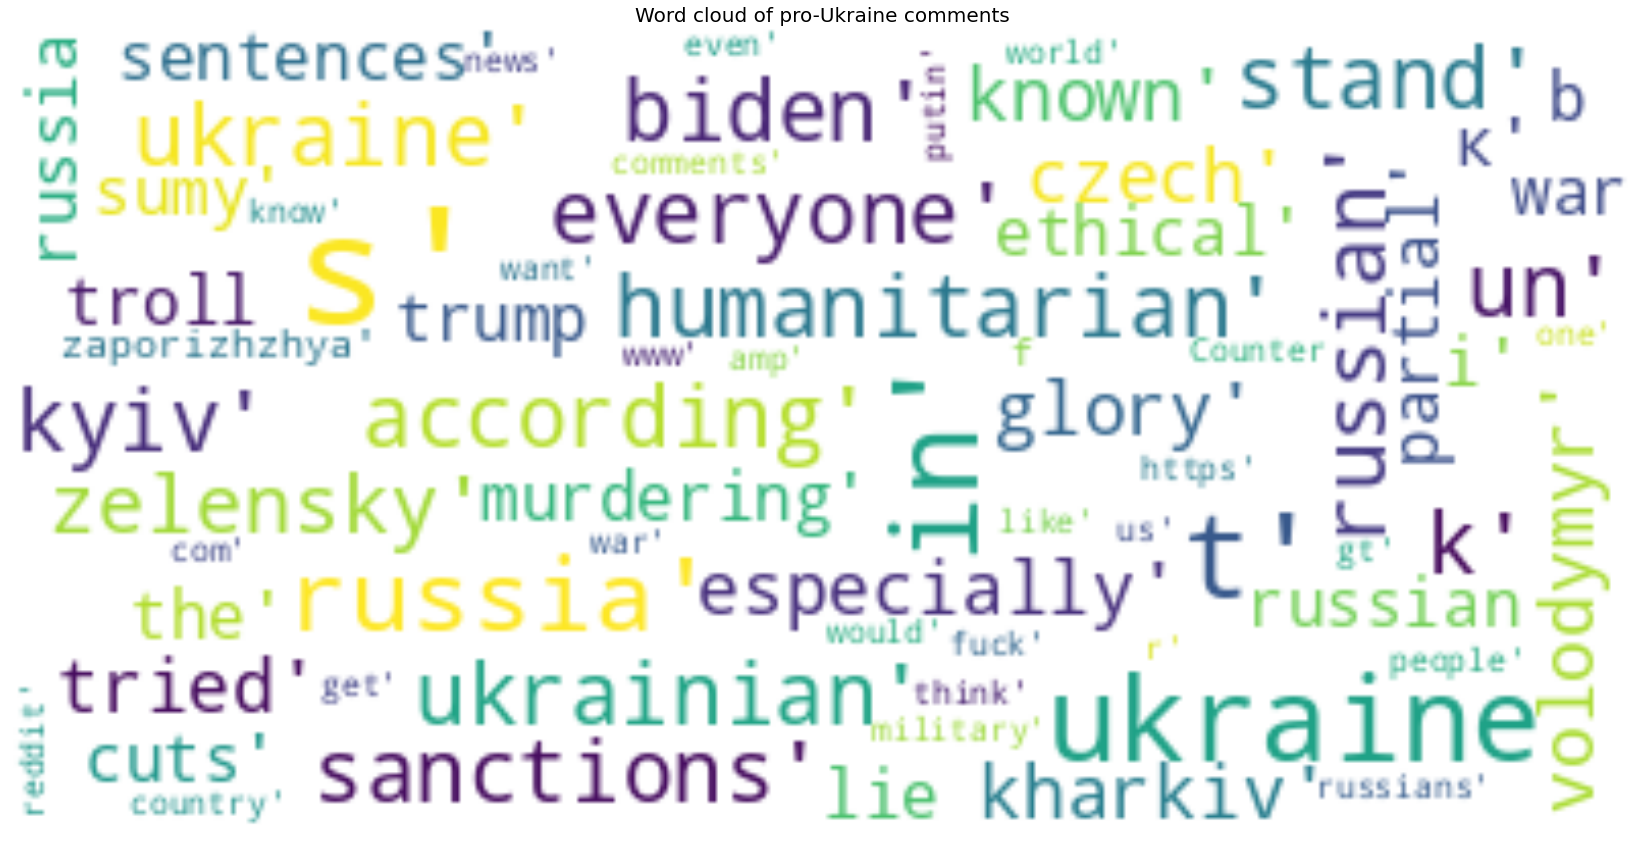

Text(0.5, 1.0, 'Word cloud of pro-Ukraine comments')

In [0]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(30,15))
ax.imshow(gen_wordcloud(count_ukr),interpolation="bilinear")
ax.axis("off")
ax.set_title("Word cloud of pro-Ukraine comments",fontsize=20)

Out[51]:

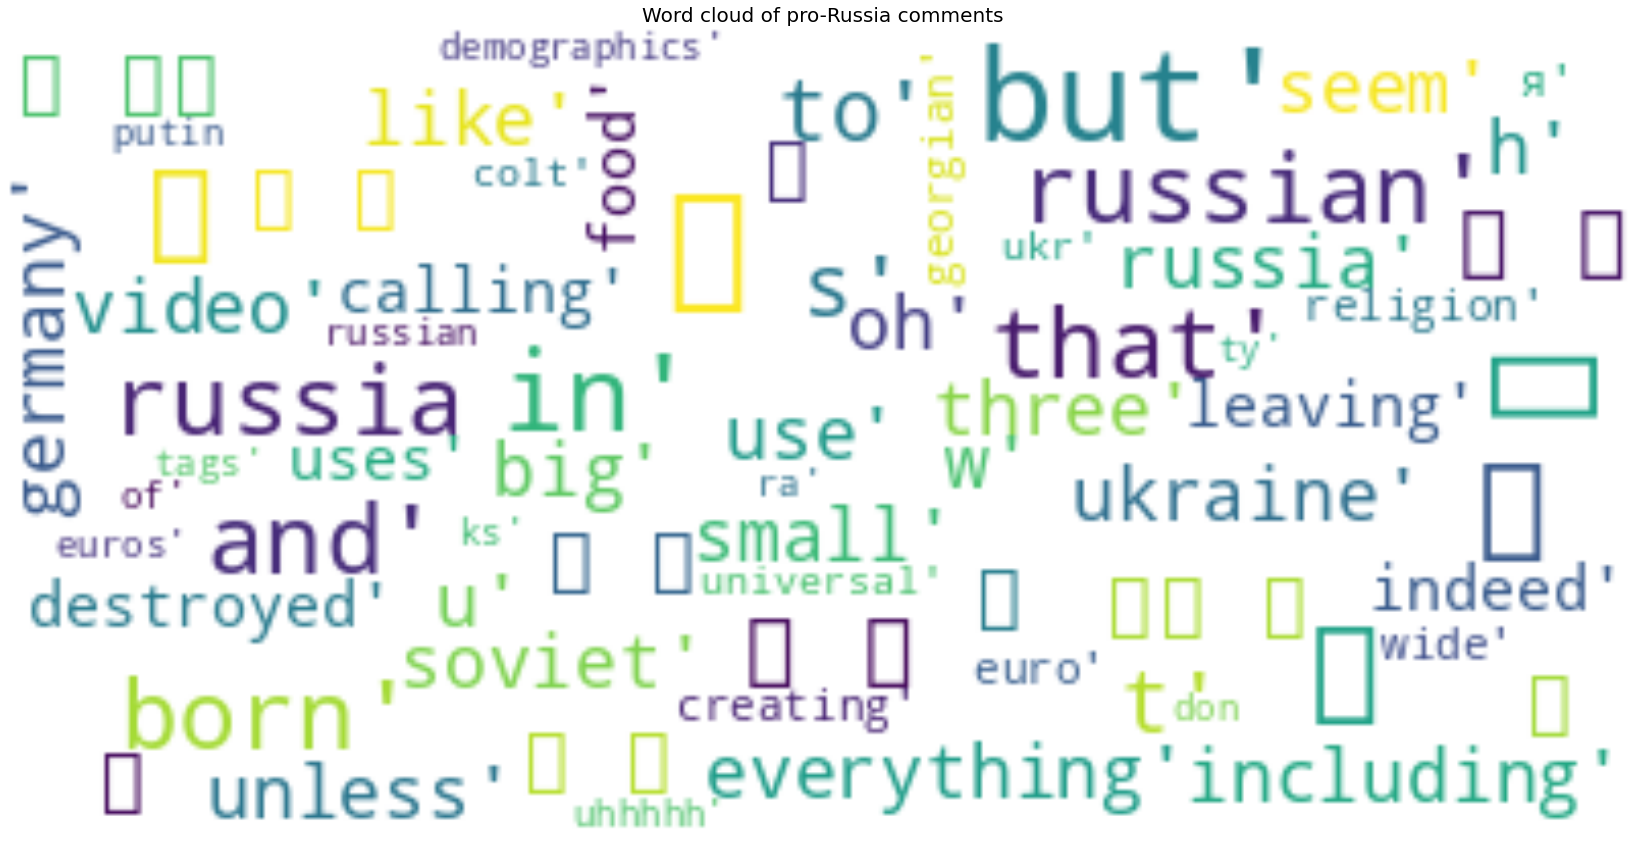

Text(0.5, 1.0, 'Word cloud of pro-Russia comments')

In [0]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(30,15))
ax.imshow(gen_wordcloud(count_rus),interpolation="bilinear")
ax.axis("off")
ax.set_title("Word cloud of pro-Russia comments",fontsize=20)